In [125]:
import os
import math
import numpy as np
from PIL import Image

import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

### Unzip MNIST-Dataet

In [84]:
import gdown

url = "https://drive.google.com/file/d/1Teb30_4NGI_6fbXj58KACnYzwhKVxPXV/view?usp=drive_link"
output = "MNIST_DATASET.tar.xz"
gdown.download(url,output)

/usr/local/lib/python3.10/dist-packages/gdown/parse_url.py:44: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=1Teb30_4NGI_6fbXj58KACnYzwhKVxPXV
  warnings.warn(
Downloading...
From: https://drive.google.com/file/d/1Teb30_4NGI_6fbXj58KACnYzwhKVxPXV/view?usp=drive_link
To: /content/MNIST_DATASET.tar.xz
82.5kB [00:00, 136MB/s]


'MNIST_DATASET.tar.xz'

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [86]:
dataset_folder = "/content/MNIST_DATASET/MNIST_DATASET"

# check for dataset existence
if os.path.exists(dataset_folder):
    print("> MNIST_DATASET folder already exists.")
else:
    print("> MNIST_DATASET folder does not exist.\n> Extracting MNIST_DATASET.tar.xz")
    import tarfile
    file = tarfile.open('/content/drive/MyDrive/IIITD/MNIST_DATASET.tar.xz')
    # upload tar.xz in runtine
    # file = tarfile.open('MNIST_DATASET.tar.xz')
    file.extractall('./MNIST_DATASET')
    file.close()

> MNIST_DATASET folder does not exist.
> Extracting MNIST_DATASET.tar.xz


In [87]:
# Set the paths for training and testing data
train_data_path = r"/content/MNIST_DATASET/MNIST_DATASET/trainingSet/trainingSet"
test_data_path = r"/content/MNIST_DATASET/MNIST_DATASET/testSet" #/testSet"

## Custom Dataset and tranformers

In [88]:
class CustomTransform:
    def __init__(self, target_size=(28, 28)):
        self.target_size = target_size

    def __call__(self, img):
        # Resize
        # img = img.resize(self.target_size, Image.ANTIALIAS)
        # Convert to NumPy array and normalize
        img_array = np.array(img, dtype=np.float32) / 255.0
        # Convert to PyTorch tensor
        img_tensor = torch.from_numpy(img_array)

        return img_tensor

In [89]:
# class MNISTDataset():
class MNISTDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.data = []

        for label in os.listdir(root):
            label_path = os.path.join(root, label)
            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                if(label.isdigit()):
                    self.data.append((img_path, int(label)))
                else:
                    self.data.append((img_path,-1))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        # img = Image.open(img_path)
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(label, dtype=torch.long)   # [label]
        return img, label

# # Define transformations (resize and convert to tensor)
# transform = transforms.Compose([
#     transforms.Resize((28, 28)),
#     transforms.ToTensor(),
#     transforms.Lambda(lambda x: x / 255.0)
# ])

# # Create the MNISTDataset instance with the custom transformation
# custom_transform = CustomTransform()
# train_dataset = MNISTDataset(root=train_data_path, transform=custom_transform)
# test_dataset = MNISTDataset(root=test_data_path, transform=custom_transform)

## Custom Dataloader

In [90]:
class CustomDataLoader:
    def __init__(self, dataset, batch_size, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.current_idx = 0

        if shuffle:
            self.shuffle_dataset()

    def __len__(self):
        return len(self.dataset) // self.batch_size

    def __iter__(self):
        self.idx_list = list(range(len(self.dataset)))
        self.batch_start_idx = 0
        return self

    def __next__(self):
        if self.batch_start_idx >= len(self.idx_list):
            raise StopIteration

        batch_end_index = min(self.batch_start_idx + self.batch_size, len(self.dataset))
        batch_indices = self.idx_list[self.batch_start_idx:batch_end_index]

        batch = [self.dataset[i] for i in batch_indices]

        # Transpose the list of tuples into a tuple of lists
        batch = list(zip(*batch))

        # Convert the data and labels to tensors
        data_tensor = torch.stack([torch.Tensor(item) for item in batch[0]])
        label_tensor = torch.stack([torch.Tensor(item) for item in batch[1]])

        # self.current_idx += self.batch_size
        self.batch_start_idx = batch_end_index

        return data_tensor, label_tensor

    def shuffle_dataset(self):
        indices = torch.randperm(len(self.dataset))
        self.dataset = [self.dataset[i] for i in indices]
        self.current_idx = 0

# custom_transform = CustomTransform()
# # Create instances of the custom dataset for training and testing
# train_dataset = MNISTDataset(root=train_data_path, transform=custom_transform)
# test_dataset = MNISTDataset(root=test_data_path, transform=custom_transform)

# # Create custom data loaders for training and testing
# train_dataloader = CustomDataLoader(dataset=train_dataset, batch_size=128, shuffle=False)
# test_dataloader = CustomDataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# # Iterate through the custom data loader
# for data, labels in train_dataloader:
#     # print("Data shape:", data.shape)
#     # print("Data shape:", data[0])
#     print("Labels shape:", labels.shape)
#     break

### sanity check

In [91]:
# Set the paths for training and testing data
train_data_path = r"/content/MNIST_DATASET/MNIST_DATASET/trainingSet/trainingSet"
test_data_path = r"/content/MNIST_DATASET/MNIST_DATASET/testSet" #/testSet"

# Create the MNISTDataset instance with the custom transformation
custom_transform = CustomTransform()
train_dataset = MNISTDataset(root=train_data_path, transform=custom_transform)
test_dataset = MNISTDataset(root=test_data_path, transform=custom_transform)

# Create custom data loaders for training and testing
train_dataloader = CustomDataLoader(dataset=train_dataset, batch_size=128, shuffle=False)
test_dataloader = CustomDataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

# # Iterate through the custom data loader
# for data, labels in train_dataloader:
#     # print("Data shape:", labels[0],data[0])
#     print("Data shape:", data.shape)
#     print("Labels shape:", labels.shape)
#     break

In [21]:
# # Create the MNISTDataset instance with the custom transformation
# custom_transform = CustomTransform()
# train_dataset = MNISTDataset(root=train_data_path, transform=custom_transform)
# test_dataset = MNISTDataset(root=test_data_path, transform=custom_transform)

# # Create custom data loaders for training and testing (your existing code)
# train_dataloader_custom = CustomDataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
# test_dataloader_custom = CustomDataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# # Now, create PyTorch DataLoader instances using your custom dataset
# train_dataloader_torch = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
# test_dataloader_torch = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# iter = 0
# # Example usage of both data loaders
# for data, labels in train_dataloader_torch:
#     print("PyTorch DataLoader - Data Shape:", data.shape, "Labels Shape:", labels.shape)

# for data, labels in train_dataloader_custom:
#     print("Custom DataLoader - Data Shape:", data.shape, "Labels Shape:", labels.shape)

## 1.

In [ ]:
# Function to measure loading time using your custom data loader
def measure_dataloader_loading_time(dataloader, batch_size,epochs = 1,full_flag = False):
    if(full_flag):
        for _ in range(epochs):
            start_time = time.time()
            for _ in dataloader:
                pass
            end_time = time.time()
            loading_time = end_time - start_time
            return loading_time

    else:
      for _ in range(epochs):
          start_time = time.time()
          for _ in dataloader:
              # print(batch_size)
              break
          end_time = time.time()
          loading_time = end_time - start_time
          return loading_time

# Batch sizes to compare
batch_sizes = [128, 256, 512, 1024]

# Initialize lists to store loading times
custom_loading_times = []
pytorch_loading_times = []

# Create the MNISTDataset instance with the custom transformation
custom_transform = CustomTransform()
train_dataset = MNISTDataset(root=train_data_path, transform=custom_transform)
test_dataset = MNISTDataset(root=test_data_path, transform=custom_transform)

epochs = 1
measure_time_for_full_dataloading = False
# Measure loading times for each batch size
for batch_size in batch_sizes:
    print(f"Currently computing loading times for {batch_size}")
    # Create your custom data loader
    custom_dataloader = CustomDataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

    # Create PyTorch's DataLoader
    pytorch_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

    # Measure loading times
    custom_loading_time = measure_dataloader_loading_time(custom_dataloader, batch_size,epochs=epochs,full_flag=measure_time_for_full_dataloading)
    pytorch_loading_time = measure_dataloader_loading_time(pytorch_dataloader,batch_size,epochs=epochs,full_flag=measure_time_for_full_dataloading)

    custom_loading_times.append(custom_loading_time)
    pytorch_loading_times.append(pytorch_loading_time)

In [23]:
print(custom_loading_times)
print(pytorch_loading_times)

[0.019575834274291992, 0.007093906402587891, 0.0057218074798583984, 0.015825748443603516]
[0.05151939392089844, 0.08754467964172363, 0.11758732795715332, 1.1712257862091064]


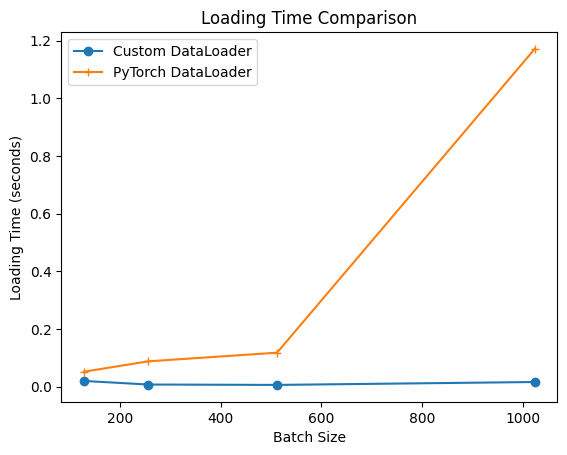

In [24]:
# Plotting
plt.plot(batch_sizes, custom_loading_times,marker='o', label='Custom DataLoader')
plt.plot(batch_sizes, pytorch_loading_times,marker='+', label='PyTorch DataLoader')
plt.xlabel('Batch Size')
plt.ylabel('Loading Time (seconds)')
plt.title('Loading Time Comparison')
plt.legend()
plt.show()

## 2
2.0 Implement a Feed-Forward neural network architecture from scratch featuring four hidden layers, each comprising minimum 32 neurons (excluding input and output layers).

2.1 Train the model using the most effective data loader identified in the previous question with ReLU activation function.

2.2 Employ the Cross-Entropy loss function and opt for the Stochastic Gradient Descent (SGD) optimizer with default parameters, setting the learning rate to 0.0003.

2.3 Plot graphs depicting the loss and accuracy during training, validation and testing for a total of 60 epochs.


### 2.0) Feed-Forward neural network architecture
##### 4.1) Sigmoid activation function
##### -1) bonus variable hidden layers (neurons and #layers)



In [225]:
# Define the custom neural network using torch
class FFNN(nn.Module):
    def __init__(self,
             input_layer_neurons: int = 28*28,
             hidden_layers: list = [32, 32, 32, 32,32],
             output_layer_neurons: int = 10,
             activation_type: str = "ReLU",
             weight_initialization: str = "He",
             zeroes_bias_initialization: bool = True,
             batch_normalization_flag: bool = False,
             BatchNormalization_then_Activation_function: bool = False):
        super(FFNN, self).__init__()

        self.input_layer_neurons = [input_layer_neurons]
        self.hidden_layers = hidden_layers
        self.output_layer_neurons = [output_layer_neurons]
        layer_sizes = self.input_layer_neurons + self.hidden_layers + self.output_layer_neurons #[28 * 28, 32, 32, 32, 32, 10]
        hl_short = (self.hidden_layers[:2]+ ["\""] + self.hidden_layers[-2:]) if len(self.hidden_layers) >= 6 else (self.hidden_layers)
        self.layers = nn.ModuleList()
        self.activation_type = activation_type
        self.weight_initialization = weight_initialization
        self.batch_normalization_flag = batch_normalization_flag
        self.zeroes_bias_initialization = zeroes_bias_initialization
        self.BatchNormalization_then_Activation_function = BatchNormalization_then_Activation_function

        print(f"Feed-Forward neural network intitialed with {len(layer_sizes)-1} layers with input layers having {self.input_layer_neurons[0]} neurons, {len(self.hidden_layers)} hidden layers having neurons {hl_short} and output layer having {self.output_layer_neurons[0]} neurons :\n"
              f">> [Activation Type: {self.activation_type}]\n"
              f">> [Weight Initialization: {self.weight_initialization}]\n"
              f">> [Zeroes Bias Initialization: {self.zeroes_bias_initialization}]\n"
              f">> [Batch Normalization Flag: {self.batch_normalization_flag}]\n"
              f">> [BatchNormalization_then_Activation_function: {self.BatchNormalization_then_Activation_function}]\n")

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        if activation_type == "ReLU":
            self.activation_function = self.relu
        elif activation_type == "Sigmoid":
            self.activation_function = self.sigmoid
        else:
            print("Activation functions supported are only \"ReLU\", \"Sigmoid\" \n Intialized with ReLU funtion as activation function ")
            self.activation_function = self.relu

        # nothing :: {epoch:validationAccuracy} == [{60:18%},{120:17%}]
        for i in range(1, len(layer_sizes)):
            linear_layer = nn.Linear(layer_sizes[i - 1], layer_sizes[i])
            self.layers.append(linear_layer)
            self.layers.append(self.activation_function)

            if batch_normalization_flag and i < len(layer_sizes) - 1:
                self.layers.append(nn.BatchNorm1d(layer_sizes[i]))
            if self.BatchNormalization_then_Activation_function:
                activation_layer = self.layers.pop(-2)
                self.layers.append(self.activation_function)

            # Weight and bias initialization
            if self.weight_initialization == "He":                              # He (normal) initialization :: [{60:85%},{120:90%}] ; He+zeros :: [{60:81%}]
                nn.init.kaiming_normal_(linear_layer.weight, nonlinearity='relu')
            elif self.weight_initialization == "Xavier":                        # Xavier/Glorot initialization :: [{60:65%},{120:83%}];
                nn.init.xavier_uniform_(linear_layer.weight)
            elif self.weight_initialization == "LeCun":                         # LeCun Initialization for linear layers :: [{60:56%},{120:80%},{180:88%}];
                nn.init.normal_(linear_layer.weight, mean=0, std=1 / math.sqrt(linear_layer.weight.size(1)))
            else:                                                               # training without any initialization (getting trained (verified by higher learning rate)) : not getting trained
              pass

            if zeroes_bias_initialization:                                      # only zero will not trainingg at all [{60:10%}]
                nn.init.zeros_(linear_layer.bias)

    def forward(self,x):
        x = x.view(-1, 28 * 28)  # Flatten the input
        for layer in self.layers:
            x = layer(x)
        return x

    def args_(self):
        hl_short = (self.hidden_layers[:2]+ ["\""] + self.hidden_layers[-2:]) if len(self.hidden_layers) >= 6 else (self.hidden_layers)
        print(f"Arguments that FFNN class takes in for neural network initialization :\n"
              f">> activation_type :: ['ReLU', 'Sigmoid']\t\t\t\t\\\\ {self.activation_type} [default] or Sigmoid //; \n"
              f">> weight_initialization = ['He', 'Xavier', 'LeCun', N/A] \t\t\\\\ {self.weight_initialization} (He (normal) initialization), {self.weight_initialization} (Xavier/Glorot initialization), {self.weight_initialization} (LeCun Initialization), random intialization [default]; // \n"
              f">> zeroes_bias_initialization = {self.zeroes_bias_initialization} \t\t\t[default] \t\\\\ All bias initialized by zeroes //; \n"
              f">> batch_normalization_flag = {self.batch_normalization_flag} \t\t\t[default] \t\\\\ Flag for batch-normalization //; \n"
              f">> BatchNormalization_then_Activation_function = {self.BatchNormalization_then_Activation_function}\t[default]\t\\\\ If True then BatchNormalization(ReLU(x_i))) i.e. Activation function followed batch normalization //; \n"
              f"\nLayers Information:\n"
              f">> Input Layer Neurons  : {self.input_layer_neurons}\t\t\t\t[default]\n"
              f">> Output Layer Neurons : {self.output_layer_neurons}\t\t\t\t[default]\n"
              f">> {len(self.hidden_layers)} Hidden Layers \t: {hl_short}\n"
              )
ffnn = FFNN()
ffnn.args_()

Feed-Forward neural network intitialed with 6 layers with input layers having 784 neurons, 5 hidden layers having neurons [32, 32, 32, 32, 32] and output layer having 10 neurons :
>> [Activation Type: ReLU]
>> [Weight Initialization: He]
>> [Zeroes Bias Initialization: True]
>> [Batch Normalization Flag: False]
>> [BatchNormalization_then_Activation_function: False]

Arguments that FFNN class takes in for neural network initialization :
>> activation_type :: ['ReLU', 'Sigmoid']				\\ ReLU [default] or Sigmoid //; 
>> weight_initialization = ['He', 'Xavier', 'LeCun', N/A] 		\\ He (He (normal) initialization), He (Xavier/Glorot initialization), He (LeCun Initialization), random intialization [default]; // 
>> zeroes_bias_initialization = True 			[default] 	\\ All bias initialized by zeroes //; 
>> batch_normalization_flag = False 			[default] 	\\ Flag for batch-normalization //; 
>> BatchNormalization_then_Activation_function = False	[default]	\\ If True then BatchNormalization(ReLU(x_i)

#### About Intialization

      
He (normal) initialization :

    weight initialization technique designed to address the vanishing/exploding gradient problem, especially in deep neural networks with rectified linear unit (ReLU) activation functions.
    it keeps the variance of activations roughly the same across different layers.

    For a layer with n input units, He initialization sets the weights from a Gaussian distribution with mean 0 and variance 2/n (or 1/n for the fan_in variant).
    Mathematically, if W is the weight matrix for a layer, He initialization is applied as: W ~ N(0, 2/n) ; n : number of input units in the layer.

    nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')

In [217]:
# Set the paths for training data
united_data_path = r"/content/MNIST_DATASET/MNIST_DATASET/trainingSet/trainingSet"

# Create the MNISTDataset instance with the custom transformation
custom_transform = CustomTransform()
united_dataset = MNISTDataset(root=united_data_path, transform=custom_transform)

# Split the dataset into training, validation, and test sets
total_size = len(united_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.5 * (total_size - train_size))
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(united_dataset, [train_size, val_size, test_size])
print(f"{len(train_dataset)}, {len(val_dataset)}, {len(test_dataset)}")

# Create custom data loaders for training, validation, and testing
train_dataloader = CustomDataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
val_dataloader = CustomDataLoader(dataset=val_dataset, batch_size=128, shuffle=False)
test_dataloader = CustomDataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

33600, 4200, 4200


#### **Accuracy** matrix
Sigmoid
    # batchNormalization(sigmoid()) {60:87%} (quick training)
    # sigmoid(batchNormalization()) {60:86%}

    # Sigmoid :: Without batch normalization NO training on 0.0003 learning rate, only able to handle vanishing gradients when lr = 3 (much higher)

    # batchNormalization(sigmoid()) {60:87%} (quick training)
    # sigmoid(batchNormalization()) {60:86%}

ReLU
    # training without any initialization (getting trained (verified by higher learning rate)) : not getting trained
    # nothing :: {epoch:validationAccuracy} == [{60:18%},{120:17%}]

    # BatchNormalization(ReLU()) + He {60:87%} (very quicker training)
    # ReLu(BatchNormalization()) + He {60:86%}

    # He (normal) initialization :: [{60:85%},{120:90%}] ; He+zeros :: [{60:81%}]
    # Xavier/Glorot initialization :: [{60:65%},{120:83%}];
    # LeCun Initialization for linear layers :: [{60:56%},{120:80%},{180:88%}];
    # only zero will not trainingg at all [{60:10%}]

### Training model

In [227]:
# Instantiate the neural network, loss function, and optimizer
# bonus part with variable number of layers and neurons in each one
train_losses, val_losses, test_losses = [], [], []
train_accuracies, val_accuracies, test_accuracies = [], [], []

num_epochs = 60
learning_rate = 0.0003
activation_type = "ReLU"          # ['ReLU', 'Sigmoid']
weight_initialization = "Xavier"      # ['He', 'Xavier', 'LeCun', N/A]
zeroes_bias_initialization = False
batch_normalization_flag = True
BatchNormalization_then_Activation_function = False

input_layer_neurons = 28*28                                     # number of features (fixed)
output_layer_neurons = 10                                       # number of classes  (fixed)
number_of_hidden_layers = 4
hidden_layers = [4 for _ in range(number_of_hidden_layers)]     # list of number of neurons in hidden layers

model = FFNN(
    input_layer_neurons = input_layer_neurons, output_layer_neurons = output_layer_neurons,
    hidden_layers = hidden_layers,
    activation_type=activation_type,
    weight_initialization=weight_initialization,
    zeroes_bias_initialization=zeroes_bias_initialization,
    batch_normalization_flag=batch_normalization_flag,
    BatchNormalization_then_Activation_function=BatchNormalization_then_Activation_function
)
model.args_()

print(f"Training model for {num_epochs} epochs\n"
      f">> [learning rate = {learning_rate}]\n")


# # Load previously trained model
# model_path = "HeInitialization_60_0003.pth"
# loaded_model = torch.load(model_path)
# model = loaded_model

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    print(f"Epoch [{str(epoch + 1).zfill(len(str(num_epochs)))}/{num_epochs}], ", end=" ")

    # Training
    model.train()
    total_train_loss, correct_train, total_train = 0.0, 0, 0

    for data, labels in train_dataloader:
        labels = labels.squeeze()
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)

        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    train_losses.append(total_train_loss / len(train_dataloader))
    train_accuracies.append(100 * correct_train / total_train)

    # Validation
    model.eval()
    total_val_loss, correct_val, total_val = 0.0, 0, 0

    with torch.no_grad():
        for data, labels in val_dataloader:
            outputs = model(data)
            loss = criterion(outputs, labels.squeeze())

            total_val_loss += loss.item()
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels.squeeze()).sum().item()

    val_losses.append(total_val_loss / len(val_dataloader))
    val_accuracies.append(100 * correct_val / total_val)

    # Testing
    model.eval()
    total_test_loss, correct_test, total_test = 0.0, 0, 0

    with torch.no_grad():
        for data, labels in test_dataloader:
            outputs = model(data)
            loss = criterion(outputs, labels.squeeze())

            total_test_loss += loss.item()
            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels.squeeze()).sum().item()

    test_losses.append(total_test_loss / len(test_dataloader))
    test_accuracies.append(100 * correct_test / total_test)

    # variables_list = [num_epochs, learning_rate, activation_type, weight_initialization,
    #                   zeroes_bias_initialization, batch_normalization_flag, BatchNormalization_then_Activation_function,
    #                   f"trn:{train_accuracies[-1]:.2f}%",f"val:{val_accuracies[-1]:.2f}",f"tst:{test_accuracies[-1]:.2f}%",".pth"]
    # variables_string = '_'.join(map(str, variables_list))
    # print("\nPath from variables and reults :: ",variables_string)

    # torch.save(model, variables_string)

    print(
        f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, "
        f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%, "
        f"Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.2f}%"
    )

Feed-Forward neural network intitialed with 5 layers with input layers having 784 neurons, 4 hidden layers having neurons [4, 4, 4, 4] and output layer having 10 neurons :
>> [Activation Type: ReLU]
>> [Weight Initialization: Xavier]
>> [Zeroes Bias Initialization: False]
>> [Batch Normalization Flag: True]
>> [BatchNormalization_then_Activation_function: False]

Arguments that FFNN class takes in for neural network initialization :
>> activation_type :: ['ReLU', 'Sigmoid']				\\ ReLU [default] or Sigmoid //; 
>> weight_initialization = ['He', 'Xavier', 'LeCun', N/A] 		\\ Xavier (He (normal) initialization), Xavier (Xavier/Glorot initialization), Xavier (LeCun Initialization), random intialization [default]; // 
>> zeroes_bias_initialization = False 			[default] 	\\ All bias initialized by zeroes //; 
>> batch_normalization_flag = True 			[default] 	\\ Flag for batch-normalization //; 
>> BatchNormalization_then_Activation_function = False	[default]	\\ If True then BatchNormalization(R

KeyboardInterrupt: 

#### Saving model

In [30]:
variables_list = [num_epochs, learning_rate, activation_type, weight_initialization,
                  zeroes_bias_initialization, batch_normalization_flag, BatchNormalization_then_Activation_function,
                  f"trn:{train_accuracies[-1]:.2f}%",f"val:{val_accuracies[-1]:.2f}",f"tst:{test_accuracies[-1]:.2f}%",".pth"]
variables_string = '_'.join(map(str, variables_list))
print("\nPath from variables and reults :: ",variables_string)

torch.save(model, variables_string)

#### Plotting curves

In [160]:
train_losses, val_losses, test_losses = train_losses, val_losses, test_losses
train_accuracies, val_accuracies, test_accuracies = train_accuracies, val_accuracies, test_accuracies

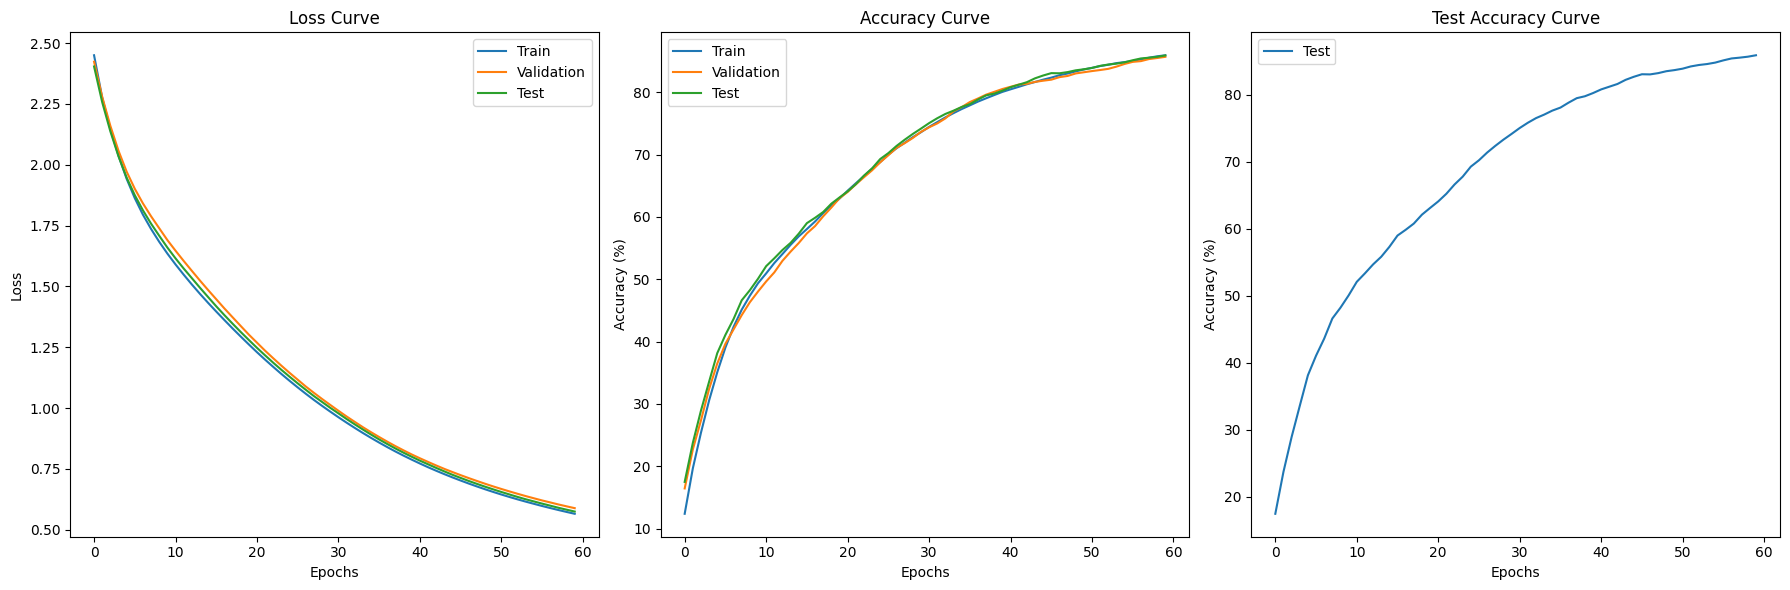

In [161]:
# Plotting the loss and accuracy curves
plt.figure(figsize=(18, 6))

# Plot Loss Curves
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.plot(test_losses, label='Test')  # New line for test loss
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy Curves
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.plot(test_accuracies, label='Test')  # New line for test accuracy
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Plot Test Accuracy
plt.subplot(1, 3, 3)
plt.plot(test_accuracies, label='Test')
plt.title('Test Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


## 3. Scratch


In [124]:
class Linear:
    def __init__(self,activation_type="Relu",HeInitialization=True):
        # Initialize weights and biases
        self.w1 = torch.randn(784, 32, requires_grad=False)
        self.b1 = torch.zeros(32, requires_grad=False)
        self.w2 = torch.randn(32, 32, requires_grad=False)
        self.b2 = torch.zeros(32, requires_grad=False)
        self.w3 = torch.randn(32, 32, requires_grad=False)
        self.b3 = torch.zeros(32, requires_grad=False)
        self.w4 = torch.randn(32, 32, requires_grad=False)
        self.b4 = torch.zeros(32, requires_grad=False)
        self.w5 = torch.randn(32, 10, requires_grad=False)
        self.b5 = torch.zeros(10, requires_grad=False)

        if activation_type == "ReLU":
            self.activation_function = F.relu
            self.activation_function_derivative = self.relu_derivative
        if activation_type == "Sigmoid":
            self.activation_function = F.sigmoid
            self.activation_function_derivative = self.sigmoid_derivative
        if(HeInitialization):
            self._initialize_weights()

    # He - initalization
    def _initialize_weights(self):
        for weight, bias in [(self.w1, self.b1), (self.w2, self.b2), (self.w3, self.b3), (self.w4, self.b4), (self.w5, self.b5)]:
            n = weight.size(1)
            bound = math.sqrt(2/n)
            nn.init.normal_(weight, mean=0, std=bound)
            nn.init.zeros_(bias)

    def softmax(self, x, dim=1):
        e_x = torch.exp(x - torch.max(x, dim=dim, keepdim=True).values)  # Subtracting max(x) for numerical stability
        return e_x / torch.sum(e_x, dim=dim, keepdim=True)

    def forward(self, x):
        # Forward pass for each layer
        self.a1 = x @ self.w1 + self.b1
        self.h1 = self.activation_function(self.a1)

        self.a2 = self.h1 @ self.w2 + self.b2
        self.h2 = self.activation_function(self.a2)

        self.a3 = self.h2 @ self.w3 + self.b3
        self.h3 = self.activation_function(self.a3)

        self.a4 = self.h3 @ self.w4 + self.b4
        self.h4 = self.activation_function(self.a4)

        self.a5 = self.h4 @ self.w5 + self.b5
        self.y_pred_prob = self.softmax(self.a5, dim=1)
        return self.y_pred_prob

    def compute_loss(self, y_pred, y_true):
        eps = 1e-6
        return -torch.sum(y_true * torch.log(y_pred + eps)) / y_true.shape[0]

    def backward(self, x, y_true, y_pred, learning_rate):
        # Output layer
        d_a5 = y_pred - y_true
        d_w5 = self.h4.t() @ d_a5
        d_b5 = d_a5.sum(0)

        # Layer 4
        d_h4 = d_a5 @ self.w5.t()
        d_h4 *= self.activation_function_derivative(self.a4)
        d_w4 = self.h3.t() @ d_h4
        d_b4 = d_h4.sum(0)

        # Layer 3
        d_h3 = d_h4 @ self.w4.t()
        d_h3 *= self.activation_function_derivative(self.a3)
        d_w3 = self.h2.t() @ d_h3
        d_b3 = d_h3.sum(0)

        # Layer 2
        d_h2 = d_h3 @ self.w3.t()
        d_h2 *= self.activation_function_derivative(self.a2)
        d_w2 = self.h1.t() @ d_h2
        d_b2 = d_h2.sum(0)

        # Layer 1
        d_h1 = d_h2 @ self.w2.t()
        d_h1 *= self.activation_function_derivative(self.a1)
        d_w1 = x.t() @ d_h1
        d_b1 = d_h1.sum(0)

        # Update weights and biases
        with torch.no_grad():
            self.w1 -= learning_rate * d_w1
            self.b1 -= learning_rate * d_b1
            self.w2 -= learning_rate * d_w2
            self.b2 -= learning_rate * d_b2
            self.w3 -= learning_rate * d_w3
            self.b3 -= learning_rate * d_b3
            self.w4 -= learning_rate * d_w4
            self.b4 -= learning_rate * d_b4
            self.w5 -= learning_rate * d_w5
            self.b5 -= learning_rate * d_b5

            # Zero gradients (manually, since we're not using autograd)
            self.zero_gradients()

    def sigmoid_derivative(self, x):
        return F.sigmoid(x) * (1 - F.sigmoid(x))

    def relu_derivative(self, x):
        return torch.where(x > 0, torch.tensor(1.0), torch.tensor(0.0))

    def zero_gradients(self):
        # Manually zero the gradients
        for param in [self.w1, self.b1, self.w2, self.b2, self.w3, self.b3, self.w4, self.b4, self.w5, self.b5]:
            if param.grad is not None:
                param.grad.zero_()

### scratch implementation
with He-initialization
> activation_function = "ReLU" -> Accuracy = 94%,94%,97% ;

> activation_function = "Sigmoid" -> Accuracy = 92%,91%,91% ;

without
> activation_function = "Sigmoid" -> Accuracy = 86%,84%,85% ;




In [34]:
activation_function = "Sigmoid" # [Sigmoid,ReLU]
HeInitialization = False
model = Linear(activation_type=activation_function,HeInitialization=HeInitialization)
num_epochs = 60
learning_rate = 0.0003

train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies = [], [], [], [], [], []

print(f"Training model of 5 layers with 32 neurons each for {num_epochs} epochs \n[learning rate is {learning_rate}]\n[Activation Function is {activation_function}]\n[HeInitialization is {HeInitialization}]\n")

starting_time_scratch = time.time()
for epoch in range(num_epochs):
    print(f"Epoch [{str(epoch + 1).zfill(len(str(num_epochs)))}/{num_epochs}], ", end=" ")

    # Training
    train_running_loss, correct_train, total_train = 0.0, 0, 0

    for data, labels in train_dataloader:
        data = data.view(-1, 784)
        labels = labels.squeeze()
        labels_one_hot = F.one_hot(labels, num_classes=10).float()

        y_pred = model.forward(data)

        loss = model.compute_loss(y_pred, labels_one_hot)
        model.backward(data, labels_one_hot, y_pred, learning_rate)

        train_running_loss += loss
        total_train += labels.size(0)
        y_pred = torch.argmax(y_pred, dim=1)
        correct_train += (y_pred == labels).sum().item()

    train_losses.append(train_running_loss / len(train_dataloader))
    train_accuracies.append(100 * correct_train / total_train)

    # Validation
    val_running_loss, correct_val, total_val = 0.0, 0, 0

    with torch.no_grad():
        for data, labels in val_dataloader:
            data = data.view(-1, 784)
            labels = labels.squeeze()
            labels_one_hot = F.one_hot(labels, num_classes=10).float()

            y_pred = model.forward(data)
            loss = model.compute_loss(y_pred, labels_one_hot)

            val_running_loss += loss
            total_val += labels.size(0)
            y_pred = torch.argmax(y_pred, dim=1)
            correct_val += (y_pred == labels).sum().item()

    val_losses.append(val_running_loss / len(val_dataloader))
    val_accuracies.append(100 * correct_val / total_val)

    # Testing
    test_running_loss, correct_test, total_test = 0.0, 0, 0

    with torch.no_grad():
        for data, labels in test_dataloader:
            data = data.view(-1, 784)
            labels = labels.squeeze()
            labels_one_hot = F.one_hot(labels, num_classes=10).float()

            y_pred = model.forward(data)
            loss = model.compute_loss(y_pred, labels_one_hot)

            test_running_loss += loss
            total_test += labels.size(0)
            y_pred = torch.argmax(y_pred, dim=1)
            correct_test += (y_pred == labels).sum().item()

    test_losses.append(test_running_loss / len(test_dataloader))
    test_accuracies.append(100 * correct_test / total_test)

    print(
        f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, "
        f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%, "
        f"Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.2f}%"
    )

ending_time_scratch = time.time()
full_run_scratch = ending_time_scratch-starting_time_scratch
print(f'Total Time taken = {full_run_scratch}')

Training model of 5 layers with 32 neurons each for 60 epochs 
[learning rate is 0.0003]
[Activation Function is Sigmoid]
[HeInitialization is False]

Epoch [01/60],  Train Loss: 2.3551, Train Accuracy: 19.17%, Val Loss: 2.1551, Val Accuracy: 25.19%, Test Loss: 2.1450, Test Accuracy: 25.07%
Epoch [02/60],  Train Loss: 1.9599, Train Accuracy: 31.70%, Val Loss: 1.9232, Val Accuracy: 34.36%, Test Loss: 1.9142, Test Accuracy: 34.24%
Epoch [03/60],  Train Loss: 1.7689, Train Accuracy: 40.43%, Val Loss: 1.7543, Val Accuracy: 42.10%, Test Loss: 1.7462, Test Accuracy: 41.21%
Epoch [04/60],  Train Loss: 1.6202, Train Accuracy: 46.68%, Val Loss: 1.6157, Val Accuracy: 48.36%, Test Loss: 1.6108, Test Accuracy: 47.93%
Epoch [05/60],  Train Loss: 1.4961, Train Accuracy: 51.16%, Val Loss: 1.4975, Val Accuracy: 52.50%, Test Loss: 1.4968, Test Accuracy: 52.26%
Epoch [06/60],  Train Loss: 1.3899, Train Accuracy: 54.95%, Val Loss: 1.3956, Val Accuracy: 55.71%, Test Loss: 1.3979, Test Accuracy: 55.38%
Epo

KeyboardInterrupt: 

#### Ploting Results

In [ ]:
# Plotting the loss and accuracy curves
plt.figure(figsize=(18, 6))

# Plot Loss Curves
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.plot(test_losses, label='Test')  # New line for test loss
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy Curves
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.plot(test_accuracies, label='Test')  # New line for test accuracy
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Plot Test Accuracy
plt.subplot(1, 3, 3)
plt.plot(test_accuracies, label='Test')
plt.title('Test Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

### Bonus 2
time calculation for scratcch with backprogation

In [ ]:
activation_function = "ReLU"
model = Linear(activation_type=activation_function)
num_epochs = 60
learning_rate = 0.0003

train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies,full_run_scratch = [], [], [], [], [], [],[]

print(f"Training model of 5 layers with 32 neurons each for {num_epochs} epochs \n[learning rate is {learning_rate}]\n[Activation Function is {activation_function}]\n")

for epoch in range(num_epochs):
    print(f"Epoch [{str(epoch + 1).zfill(len(str(num_epochs)))}/{num_epochs}], ", end=" ")

    # Training
    train_running_loss, correct_train, total_train = 0.0, 0, 0

    starting_time_sratch_epoch = time.time()
    for data, labels in train_dataloader:
        data = data.view(-1, 784)
        labels = labels.squeeze()
        labels_one_hot = F.one_hot(labels, num_classes=10).float()

        y_pred = model.forward(data)

        loss = model.compute_loss(y_pred, labels_one_hot)
        model.backward(data, labels_one_hot, y_pred, learning_rate)

        train_running_loss += loss
        total_train += labels.size(0)
        y_pred = torch.argmax(y_pred, dim=1)
        correct_train += (y_pred == labels).sum().item()
    ending_time_scratch_epoch = time.time()
    full_run_scratch.append(ending_time_scratch_epoch-starting_time_sratch_epoch)

    train_losses.append(train_running_loss / len(train_dataloader))
    train_accuracies.append(100 * correct_train / total_train)

    print(
        f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, "
        # f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%, "
        # f"Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.2f}%"
    )

print(f'Total Time taken = {sum(full_run_scratch)}, minimun epoch timing = {min(full_run_scratch)}')
print(full_run_scratch)

In [ ]:
print(f'Total Time taken = {sum(full_run_scratch)}, minimun epoch timing = {min(full_run_scratch)}')
print(full_run_scratch)

plt.plot(full_run_scratch)

# Add labels and title
plt.xlabel('#epochs')
plt.ylabel('Time per epoch')
plt.title('Time for training')

# Show the plot
plt.show()

https://colab.research.google.com/drive/1GW0p__zZTYMNKSA3nE4eFnbRBK4KyoS1?usp=sharing